# Parsing top-down (caso deterministico)

In [ ]:
from liblet import (
    Production, 
    Grammar, 
    Derivation, 
    ProductionGraph, 
    Stack,
    Table,
    Tree,
    closure, 
    warn, 
    show_calls, 
    union_of, 
    dod2table, 
    dict2table,
    __version__)

# Alla fine ho scritto una classe Table, quindi dovete aggiornare…

__version__

'1.2.2-beta'

La necessità di seguire tutti i possibili cammini nel grafo che simula la computazione del NPDA deriva dal fatto che (tra l'altro), per un certo simbolo $A$ in cima alla pila e il primo terminale $a$ non ancora elaborato, ci sono più produzioni da considerare.

Cominciamo a considerare alcune restrizioni sulla grammatica che potrebbero semplificarci la vita. Dapprima assumiamo che non ci siano ε-regole. Quindi immaginiamo che la grammatica sia tale per cui possiamo pre-computare una tabella che, in posizione $(A, a)$ indichi una sola produzione possibile.

In tal caso il processo di parsing si semplificherebbe come segue:

In [ ]:
def parse_noε(G, TABLE, INPUT):
    deriv  = Derivation(G)
    stack = Stack(['#', G.S])
    rest = tuple(INPUT) + ('#', )
    while stack:
        top = stack.pop()
        first, *other = rest
        if top in G.T | {'#'}:
            if first == top: 
                rest = other
            else:
                warn('Expecting {}, got {}.'.format(top, first))
                return None
        else:
            P = TABLE[top, first]
            if P is None:
                warn('No production for ({}, {}) at {}.'.format(top, first, deriv) )
                return None 
            deriv = deriv.leftmost(P)
            for X in reversed(P.rhs): stack.push(X)
    return deriv

Abbiamo adoperato l'usuale "trucco" di mettere un simbolo distinto `#` in fondo alla pila e alla parola: l'unico modo di esaurire la pila (e quindi uscire dal ciclo `while` senza che venga emesso un *warning*) è che parola e pila si esauriscano in modo concorde.

Ma come costruire `TABLE`?

## Caso SLL(1)

Se la grammatica è tale per cui, per ciascun non terminale, le sue alternative iniziano tutte con terminali distinti, è molto facile!

In [ ]:
# fig. 8.4. pag. 238

G = Grammar.from_string("""
S -> a B
B -> b | a B b
""")
G

Grammar(N={B, S}, T={a, b}, P=(S -> a B, B -> b, B -> a B b), S=S)

In [ ]:
def compute_simple_table(G):
    
    TABLE = Table(2, no_reassign = True)

    for P in G.P:
        A, (a, *α) = P
        TABLE[A, a] = P

    return TABLE

Qui si usa un oggetto `Table`, il valore `2` indica che la tabella ha dimensione 2, ossia ha righe e colonne…


In [ ]:
TABLE = compute_simple_table(G)
TABLE

In [ ]:
d = parse_noε(G, TABLE, list('aabb'))
d

S -> a B -> a a B b -> a a b b

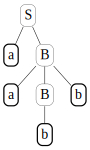

In [ ]:
ProductionGraph(d)

Possono accadere due errori di parsing… o perché manca una produzione adatta, o perché l'ultima produzione utilizzata comporta che l'algoritmo si aspetti un carattere che manca nell'input…

In [ ]:
parse_noε(G, TABLE, list('aac'))

No production for (B, c) at S -> a B -> a a B b.


In [ ]:
parse_noε(G, TABLE, list('aabc'))

Expecting b, got c.


### E se non è "semplice"?

La costruzione della tabella è in grado, di accorgersi che stiamo tentando di assegnare di nuovo un valore per un certo $(A, a)$… (si tratta del parametro `no_reassign = True` usato nella costruzione di `Table`).

In [ ]:
# fig. 8.1, pag. 236

G = Grammar.from_string("""
S -> a B | b A
A -> a | a S | b A A
B -> b | b S | a B B
""")

In [ ]:
compute_simple_table(G)

Table already contains value A -> a for (A, a)
Table already contains value B -> b for (B, b)


### Un esempio più naturale: notazione prefissa

Torniamo a consideare una grammatica SLL(1) forse più naturale della prima da cui siamo partiti: una grammatica per operazioni aritmetiche in [notazione polacca](https://en.wikipedia.org/wiki/Polish_notation).

In [ ]:
G = Grammar.from_string("""
E -> + E E | - E E | * E E | / E E | t
""")
G

Grammar(N={E}, T={*, +, -, /, t}, P=(E -> + E E, E -> - E E, E -> * E E, E -> / E E, E -> t), S=E)

In [ ]:
TABLE = compute_simple_table(G)
TABLE

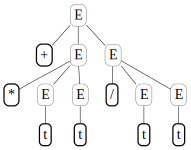

In [ ]:
ProductionGraph(parse_noε(G, TABLE, '+ * t t / t t'.split()))

### <span style="color: red;">Esercizio per casa</span>

Sapreste modificare `parse_noε` perché restituisca, invece della derivazione, il valore dell'espressione aritmetica? Sapreste integrarlo con un tokenizzatore che consenta di sostiuire numeri interi al terminale `t`?

Saprese trasformare gli alberi prodotti da `parse_noε` in modo che nodi siano operandi o opreatori, come nell'esempio seguente?

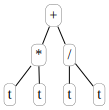

In [ ]:
Tree.from_lol(['+', ['*', ['t'], ['t']], ['/', ['t'], ['t']]])

## Caso LL(1) (senza ε-regole), gli insiemi `FIRST` 

Se la grammatica non è "semplice" il caso non è disperato (almeno se non ci sono ε-regole). 

Supponiamo di conoscere, per ogni forma sentenziale $\omega$, qual'è il primo terminale $t$ che (eventualmente) produrrà; detto in formule, supponiamo di conoscere l'insieme $\operatorname{FIRST}(\omega) = \{ t \in T \mid \omega\overset{*}{\to} t\gamma, \gamma\in (N\cup T)^+ \}$. 

Allora potremmo determinare `TABLE` come segue:

In [ ]:
def compute_table(G):
    
    TABLE = Table(2, no_reassign = True)

    FIRST = compute_first(G)
    
    for P in G.P:
        A, (B, *β) = P
        for a in FIRST[B]:        
            TABLE[A, a] = P

    return TABLE

Osservate che, data la produzione $A\to B\beta$ (con $\beta$ eventualmente vuota), invece di usare $\operatorname{FIRST}(B\beta)$ ci siamo contentati di $\operatorname{FIRST}(B)$ dal momento che (in assenza di ε-regole) evidentemente se $B\beta\overset{*}{\to} t\gamma$ allora $B\overset{*}{\to} t\gamma'$ (dove $\gamma'$ è un prefisso di $\gamma$).

Inoltre, la definizione di $\operatorname{FIRST}$ suggerisce un semplice modo ricorsivo per calcolare $\operatorname{FIRST}(X)$:

* se $X\in T$ allora per forza $\operatorname{FIRST}(X) = \{X\}$;
* viceversa, per tutte le produzioni $X\to Y\alpha$, doveremo 
aggiungere $\operatorname{FIRST}(Y)$ a $\operatorname{FIRST}(X)$.

In [ ]:
def compute_first(G):

    def recursive_first(X): # X è G.T | G.N
        return union_of(
            recursive_first(Y)
            for Y, *α in G.alternatives(X) if Y != X # occhio alla ricorsione a sinistra!
        ) if X in G.N else {X}
    
    FIRST = Table(1)
    for X in G.N | G.T: FIRST[X] = recursive_first(X)
        
    return FIRST

Proviamo cosa accade con questa grammatica

In [ ]:
# fig. 8.7, pag. 240

G = Grammar.from_string("""
Session -> Fact Session | Question
Session -> ( Session ) Session
Fact -> ! STRING
Question -> ? STRING
""")
G

Grammar(N={Fact, Question, Session}, T={!, (, ), ?, STRING}, P=(Session -> Fact Session, Session -> Question, Session -> ( Session ) Session, Fact -> ! STRING, Question -> ? STRING), S=Session)

In [ ]:
FIRST = compute_first(G)
FIRST.restrict_to(G.N) # ci interessano solo le righe relative ai non terminali

Correttamente, il non terminale `Session` può produrre parole che iniziano con `!`, `?` oppure `(`. Ora calcoliamo `TABLE` 

In [ ]:
TABLE = compute_table(G)
TABLE

Ora possiamo usare esattamente lo stesso `parse_noε`, passando questa tabella, per derivare una parola

In [ ]:
INPUT = '! STRING ! STRING ? STRING #'.split()

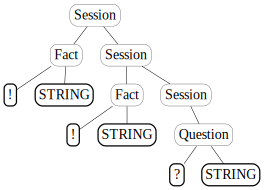

In [ ]:
ProductionGraph(parse_noε(G, TABLE, INPUT))

# <span style="color: red;">Approfondimento per casa</span>: cosa accade con le ε-regole? 

Consideriamo la seguente versione più "naturale" della precedente grammatica:


In [ ]:
# fig. 8.9, pag. 242

G = Grammar.from_string("""
Session -> Facts Question | ( Session ) Session
Facts -> Fact Facts | ε
Fact -> ! STRING
Question -> ? STRING
""")
G

Grammar(N={Fact, Facts, Question, Session}, T={!, (, ), ?, STRING}, P=(Session -> Facts Question, Session -> ( Session ) Session, Facts -> Fact Facts, Facts -> ε, Fact -> ! STRING, Question -> ? STRING), S=Session)

## Estendere il calcolo di `FIRST` al caso con ε-regole

Evidentemente non potremo più semplificarci la vita considerando $\operatorname{FIRST}(B\beta) = \operatorname{FIRST}(B)$, perché se $B\to\varepsilon$ (altrimenti detto $\varepsilon\in \operatorname{FIRST}(B)$ per prima cosa non è detto che $\varepsilon\in \operatorname{FIRST}(B\beta)$ (perché potrebbe essere che $\varepsilon\not\in \operatorname{FIRST}(\beta)$), ma sopratutto dovremo aggiungere $\operatorname{FIRST}(\beta)$ a $\operatorname{FIRST}(B\beta)$ per tenere conto del caso in cui la prima produzione sia proprio quella che "fa sparire" $B$!

Ovviamente il ragionamento interessa tutti i suffissi di una forma sentenziale, che possono essere elencati come segue

In [ ]:
def suffixes(α):
    for i in range(len(α)): 
        yield α[i:]

Siamo pronti per aggiornare il caloclo di `FIRST`, questa volta per semplificarci la vita useremo una chiusura:

In [ ]:
def compute_εfirst(G):

    FIRST = Table(1, element = set) # questo significa che gli elementi dell tabella sono insiemi

    # per prima cosa, il caso banele 
    for t in G.T: FIRST[(t, )] = {t} # attensione, gli indici sono forme sentenziali, ossia tuple!
        
    # qualche caso "extra" che ci verrà comodo poi    
    FIRST[tuple()] = {'ε'}
    FIRST[('ε', )] = {'ε'}
    FIRST[('#', )] = {'#'}

    @closure
    def update_with_suffixes(FIRST):
        for N, α in G.P:
            FIRST[(N, )] |= FIRST[α]
            for γ in suffixes(α):
                A, *β = γ
                FIRST[γ] |= FIRST[(A, )] - {'ε'}
                if 'ε' in FIRST[(A, )]: FIRST[γ] |= FIRST[β]
        return FIRST

    return update_with_suffixes(FIRST)

In [ ]:
FIRST = compute_εfirst(G)
FIRST.restrict_to({(X, ) for X in G.N})

Quanto ottenuto fin qui è corretto, ma `FIST` contiene valori solo per certe forme sentenziali, non per tutte. Non è però difficile estenderlo in modo che funzioni in generale.

Ragionando in maniera ricorsiva (come abbiamo fatto in `compute_εfirst`) è possibile passare da un insieme ad una funzione che calcoli $\operatorname{FIRST}(\omega)$ qualunque sia $\omega$

In [ ]:
def make_first_function(FIRST):
    @show_calls(True)
    def FIRSTf(ω):
        if not ω: return {'ε'}
        X, *γ = ω
        fx = FIRST[(X, )]
        if 'ε' in fx:
            return (fx - {'ε'}) | FIRSTf(γ)
        else:
            return fx
    return FIRSTf

Possiamo provarla su una forma addirittura non derivabile da $S$

In [ ]:
FIRSTf = make_first_function(FIRST)

In [ ]:
FIRSTf(('Facts', 'Facts', 'Question', '#' ))

┌FIRSTf(('Facts', 'Facts', 'Question', '#'))
│┌FIRSTf(['Facts', 'Question', '#'])
││┌FIRSTf(['Question', '#'])
││└─ {'?'}
│└─ {'!', '?'}
└─ {'!', '?'}


{'!', '?'}

Ora la nostra speranza è poter calcolare `TABLE` a partire da `FRISTf`, ma purtroppo è impossibile auspicarsi di poter decidere che produzione usare considerando solo il simbolo $A$ in cima alla pila, dato che potrebbe darsi il caso che $A\to\varepsilon$.

## Estendere il calcolo di  `TABLE` al caso con ε-regole

Violando completamente l'idea di avere a che fare con un automa a pila, dobbiamo consentire ad ogni passo che venga ispezionata tutta la pila! Detto altrimenti, dobbiamo pensare ad una funzione `TABLEf` che, dato il prossimo non terminale e *tutta* la pila, ci indichi quale produzione usare:

In [ ]:
def make_table_function(G, FIRSTf):
    
    #@show_calls(True)
    def TABLEf(stack, a):
        P = None
        *Γ, A = list(stack) # la pila è (Γ, A)
        for α in G.alternatives(A):
            γ = α + tuple(reversed(Γ)) # la forma sentenziale è α seguita da Γ (rovesciato)
            if a in FIRSTf(γ):
                if P is None: 
                    P = Production(A, α)
                else:
                    warn('Conflict: γ = {}, a = {}, prediction was {}'.format(γ, a, P))
        return P
    
    return TABLEf

La logica è che data una pila $(\Gamma, A)$ una produzione $A\to \alpha$ è un buon candidato visto il terminale $a$ se accade che $a\in FIRST(\alpha\Gamma^R)$ dove $\Gamma^R$ è la parola ottenuta concatenando i simboli sulla pila da quello più in basso a quello più in alto.

In [ ]:
TABLEf = make_table_function(G, FIRSTf)

## Il parser Full LL(1)

Ora manca qualche piccolo aggiustamento a `parse_noε` per trasformarlo in un parser *full LL(1)* che chiameremo `full_parse`; le principali differenze sono:

* ignorare le $\varepsilon$ aggiunti in pila (per via delle ε-regole),
* usare la funzione `TABLEf` (basata sulla funzione `FIRSTf`) al posto della tabella `TABLE` (basata sulla tabella `FIRST`.

Ovviamente il "piccolo" aggiustamento ha un impatto notevole sul tempo di calcolo!

In [ ]:
def full_parse(G, TABLEf, INPUT):
    deriv = Derivation(G)
    rest = tuple(INPUT) + ('#', )
    stack = Stack(['#', G.S])
    while stack:
        copy = stack.copy()
        top = stack.pop()
        if top == 'ε': continue
        first, *other = rest
        if top in G.T | {'#'}:
            if first == top:
                rest = other
            else:
                warn('Expecting {}, got {}.'.format(top, first))
                return None
        else:
            P = TABLEf(copy, first)
            if P is None:
                warn('No prediction for ({}, {}) at {}.'.format(top, first, deriv) )
                return None 
            deriv = deriv.leftmost(P)
            for X in reversed(P.rhs): stack.push(X)
    return deriv

Proviamo ad effettuare il parse della setssa parola di prima

In [ ]:
d = full_parse(G, TABLEf, INPUT)

┌FIRSTf(('Facts', 'Question', '#'))
│┌FIRSTf(['Question', '#'])
│└─ {'?'}
└─ {'!', '?'}
┌FIRSTf(('(', 'Session', ')', 'Session', '#'))
└─ {'('}
┌FIRSTf(('Fact', 'Facts', 'Question', '#'))
└─ {'!'}
┌FIRSTf(('ε', 'Question', '#'))
│┌FIRSTf(['Question', '#'])
│└─ {'?'}
└─ {'?'}
┌FIRSTf(('!', 'STRING', 'Facts', 'Question', '#'))
└─ {'!'}
┌FIRSTf(('Fact', 'Facts', 'Question', '#'))
└─ {'!'}
┌FIRSTf(('ε', 'Question', '#'))
│┌FIRSTf(['Question', '#'])
│└─ {'?'}
└─ {'?'}
┌FIRSTf(('!', 'STRING', 'Facts', 'Question', '#'))
└─ {'!'}
┌FIRSTf(('Fact', 'Facts', 'Question', '#'))
└─ {'!'}
┌FIRSTf(('ε', 'Question', '#'))
│┌FIRSTf(['Question', '#'])
│└─ {'?'}
└─ {'?'}
┌FIRSTf(('?', 'STRING', '#'))
└─ {'?'}


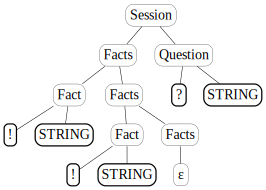

In [ ]:
ProductionGraph(d)

### Un esempio più interessante

Come esempio più "interessante" consideriamo una grammatica per espressioni aritmentiche parentesizzate.

In [ ]:
# MCD, fig. 3.4, pag. 123

G = Grammar.from_string("""
input -> expression
expression -> term rest_expression
term -> IDENTIFIER | parenthesized_expression 
parenthesized_expression -> ( expression ) 
rest_expression -> + expression | ε
""")

In [ ]:
FIRST = compute_εfirst(G)
FIRST.restrict_to({(X, ) for X in G.N})

In [ ]:
FIRSTf = make_first_function(FIRST)
TABLEf = make_table_function(G, FIRSTf)

In [ ]:
INPUT = 'IDENTIFIER + ( IDENTIFIER )'.split()
d = full_parse(G, TABLEf, INPUT)

┌FIRSTf(('expression', '#'))
└─ {'IDENTIFIER', '('}
┌FIRSTf(('term', 'rest_expression', '#'))
└─ {'IDENTIFIER', '('}
┌FIRSTf(('IDENTIFIER', 'rest_expression', '#'))
└─ {'IDENTIFIER'}
┌FIRSTf(('parenthesized_expression', 'rest_expression', '#'))
└─ {'('}
┌FIRSTf(('+', 'expression', '#'))
└─ {'+'}
┌FIRSTf(('ε', '#'))
│┌FIRSTf(['#'])
│└─ {'#'}
└─ {'#'}
┌FIRSTf(('term', 'rest_expression', '#'))
└─ {'IDENTIFIER', '('}
┌FIRSTf(('IDENTIFIER', 'rest_expression', '#'))
└─ {'IDENTIFIER'}
┌FIRSTf(('parenthesized_expression', 'rest_expression', '#'))
└─ {'('}
┌FIRSTf(('(', 'expression', ')', 'rest_expression', '#'))
└─ {'('}
┌FIRSTf(('term', 'rest_expression', ')', 'rest_expression', '#'))
└─ {'IDENTIFIER', '('}
┌FIRSTf(('IDENTIFIER', 'rest_expression', ')', 'rest_expression', '#'))
└─ {'IDENTIFIER'}
┌FIRSTf(('parenthesized_expression', 'rest_expression', ')', 'rest_expression', '#'))
└─ {'('}
┌FIRSTf(('+', 'expression', ')', 'rest_expression', '#'))
└─ {'+'}
┌FIRSTf(('ε', ')', 'rest_expression', 

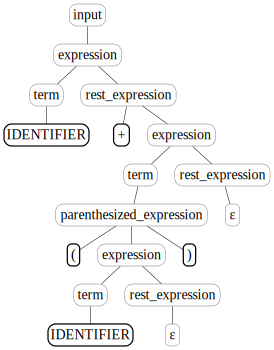

In [ ]:
ProductionGraph(d)